In [1]:
%load_ext jupyter_black

In [2]:
from copy import deepcopy
from collections import Counter
from typing import Dict, Any
from IPython.display import display
from graphviz import Digraph
from scipy.optimize import minimize
from sklearn.datasets import load_iris
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.ensemble import RandomForestClassifier as SklearnRandomForestClassifier
import numpy as np
import numpy.typing as npt
import pandas as pd

In [3]:
def entropy(y: npt.ArrayLike) -> float:
    """Calculate the entropy of a target array."""
    _, counts = np.unique(y, return_counts=True)
    probs = counts / y.shape[0]
    return -np.sum(probs * np.log(probs + 1e-10))


class DecisionTreeClassifier(BaseEstimator, ClassifierMixin):
    """
    Decision tree classifier, which can be trained, can predict class labels(miraculously) and display itself if used in a frontend environment.
    """

    def __init__(
        self,
        tree: dict = None,
        features: list = None,
        n_leaves: int = None,
        max_depth: int = None,
        min_samples_split: int = None,
        min_samples_leaf: int = None,
    ):
        if not tree is None:
            self._tree = deepcopy(tree)
        else:
            self._tree = {}
        if not features is None:
            self._features = deepcopy(features)
        else:
            self._features = []
        self._n_leaves = 0 if max_depth is None else n_leaves
        self._max_depth = -1 if max_depth is None else max_depth
        self._min_samples_split = 2 if min_samples_split is None else min_samples_split
        self._min_samples_leaf = 1 if min_samples_leaf is None else min_samples_leaf

    def fit(
        self,
        X: npt.ArrayLike,
        y: npt.ArrayLike,
        features: list = None,
        cat_features: list = None,
    ) -> None:
        """Fit the decision tree to passed data."""

        if features is None:
            self._features = [f"x_{i}" for i in range(X.shape[1])]
        else:
            self._features = features

        if cat_features is None:
            self._cat_features = []
        else:
            self._cat_features = cat_features

        if isinstance(y[0], str):
            self._prediction_dtype = "object"
        else:
            self._prediction_dtype = "int64"

        self._tree = DecisionTreeClassifier._c45_algorithm(
            X,
            y,
            self._features,
            max_depth=self._max_depth,
            min_samples_leaf=self._min_samples_leaf,
            min_samples_split=self._min_samples_split,
            cat_features=self._cat_features,
        )
        self._n_leaves = DecisionTreeClassifier._compute_subtree_leaves(self._tree)

    def predict(self, X: npt.ArrayLike) -> npt.ArrayLike:
        """Predict class labels for given data."""
        ans = np.zeros((X.shape[0],), dtype=self._prediction_dtype)
        for i in range(ans.shape[0]):
            node = self._tree
            while "children" in node:
                feature_id = self._features.index(node["feature"])
                if node["feature"] in self._cat_features:
                    node = node["children"][X[i, feature_id]]
                else:
                    node = (
                        node["children"][f"<={node['threshold']:0.2f}"]
                        if X[i, feature_id] <= node["threshold"]
                        else node["children"][f">{node['threshold']:0.2f}"]
                    )
            ans[i] = node["majority_class"]
        return ans

    # =============================================================================
    # Tree construction
    # =============================================================================

    def _c45_algorithm(
        X: npt.ArrayLike,
        y: npt.ArrayLike,
        features: list,
        max_depth: int,
        min_samples_split: int,
        min_samples_leaf: int,
        cat_features: list,
    ) -> Dict[str, Any]:
        """Recursively build an C4.5 decision tree."""

        majority_class = DecisionTreeClassifier._majority_class(y)
        error = np.sum(y != majority_class)

        # Base case: all samples same class
        if len(set(y)) == 1 or X.shape[1] < 1:
            return {"majority_class": majority_class, "error": error}

        # Node contains not enough elements to split
        if len(y) < min_samples_split:
            return {"majority_class": majority_class, "error": error}

        # Max tree depth is reached
        if max_depth == 0:
            return {"majority_class": majority_class, "error": error}

        best_id, best_feature, threshold = DecisionTreeClassifier._select_best_feature(
            X, y, features, cat_features
        )
        feature_values = np.unique(X[:, best_id])
        new_features = features.copy()
        new_features.remove(best_feature)

        tree = {
            "feature": best_feature,
            "majority_class": majority_class,
            "children": {},
            "error": error,
        }

        if best_feature in cat_features:
            for value in feature_values:
                mask = X[:, best_id] == value
                X_sub, y_sub = np.delete(X, best_id, axis=1)[mask], y[mask]
                if len(y_sub) < min_samples_leaf:
                    child_majority_class = DecisionTreeClassifier._majority_class(y_sub)
                    tree["children"][value] = {
                        "majority_class": child_majority_class,
                        "error": np.sum(y_sub != child_majority_class),
                    }
                else:
                    tree["children"][value] = DecisionTreeClassifier._c45_algorithm(
                        X_sub,
                        y_sub,
                        new_features,
                        max_depth=max_depth - 1,
                        min_samples_leaf=min_samples_leaf,
                        min_samples_split=min_samples_split,
                        cat_features=cat_features,
                    )
        else:
            mask = X[:, best_id] <= threshold
            not_mask = np.logical_not(mask)
            if (
                np.sum(mask) >= min_samples_leaf
                and (mask.shape[0] - np.sum(mask)) >= min_samples_leaf
            ):
                tree["threshold"] = threshold
                X_sub, y_sub = np.delete(X, best_id, axis=1)[mask], y[mask]
                tree["children"][f"<={threshold:0.2f}"] = (
                    DecisionTreeClassifier._c45_algorithm(
                        X_sub,
                        y_sub,
                        new_features,
                        max_depth=max_depth - 1,
                        min_samples_leaf=min_samples_leaf,
                        min_samples_split=min_samples_split,
                        cat_features=cat_features,
                    )
                )

                X_sub, y_sub = np.delete(X, best_id, axis=1)[not_mask], y[not_mask]
                tree["children"][f">{threshold:0.2f}"] = (
                    DecisionTreeClassifier._c45_algorithm(
                        X_sub,
                        y_sub,
                        new_features,
                        max_depth=max_depth - 1,
                        min_samples_leaf=min_samples_leaf,
                        min_samples_split=min_samples_split,
                        cat_features=cat_features,
                    )
                )

        return tree

    def _majority_class(y: npt.ArrayLike):
        return Counter(y).most_common(1)[0][0]

    def _gain_function(
        X: npt.ArrayLike, y: npt.ArrayLike, feature_idx: int, cat_feature: bool
    ) -> float:
        """Calculate gain for a given feature."""

        if cat_feature is None or cat_feature == False:

            def target_fn(theta: float):
                mask_left = X[:, feature_idx] <= theta
                mask_right = X[:, feature_idx] > theta
                return mask_left.shape[0] / y.shape[0] * entropy(
                    y[mask_left]
                ) + mask_right.shape[0] / y.shape[0] * entropy(y[mask_right])

            minimize_result = minimize(target_fn, x0=np.mean(X[:, feature_idx]))
            ans = {"value": minimize_result.fun, "threshold": minimize_result.x[0]}
        else:
            values, counts = np.unique(X[:, feature_idx], return_counts=True)
            probs = counts / y.shape[0]
            entropies = np.array(
                list(
                    map(
                        lambda x: entropy(y[X[:, feature_idx] == x]),
                        values,
                    )
                )
            )
            ans = {"value": np.sum(probs * entropies), "threshold": None}

        return ans

    def _select_best_feature(
        X: npt.ArrayLike, y: npt.ArrayLike, features: list, cat_features: list
    ) -> list:
        """Select the feature with the highest information gain."""
        gains = [
            DecisionTreeClassifier._gain_function(X, y, i, feature in cat_features)
            for i, feature in enumerate(features)
        ]
        best_idx = np.argmin(gain["value"] for gain in gains)
        return [best_idx, features[best_idx], gains[best_idx]["threshold"]]

    # =============================================================================
    # Tree pruning
    # =============================================================================

    def get_pruned_tree(self, alpha: float) -> Dict:
        """Prune the tree using cost-complexity pruning with parameter `alpha`."""
        ans = DecisionTreeClassifier(
            tree=self._tree,
            features=self._features,
            n_leaves=self._n_leaves,
            max_depth=self._max_depth,
            min_samples_leaf=self._min_samples_leaf,
            min_samples_split=self._min_samples_split,
        )
        ans._cat_features = deepcopy(self._cat_features)
        ans._prediction_dtype = deepcopy(self._prediction_dtype)
        return ans

    def prune_tree(self, alpha: float) -> None:
        """Prune the underlying decision tree using cost-complexity pruning with predefines `alpha`."""
        self._tree = DecisionTreeClassifier._cost_comprexity_pruning(
            self._tree, alpha, inplace=True
        )

    def _compute_subtree_error(tree: Dict) -> int:
        """Calculate the total misclassification error of a (sub)tree."""

        if not "children" in tree:
            return tree["error"]

        total_error = 0
        for child in tree["children"]:
            total_error += DecisionTreeClassifier._compute_subtree_error(
                tree["children"][child]
            )

        return total_error

    def _compute_subtree_leaves(tree: Dict) -> int:
        """Count the number of leaf nodes in a (sub)tree."""
        if not "children" in tree:
            return 1

        total_leaves = 0
        for child in tree["children"]:
            total_leaves += DecisionTreeClassifier._compute_subtree_leaves(
                tree["children"][child]
            )

        return total_leaves

    def _collect_pruning_candidates(tree: Dict, candidates: list) -> None:
        """Collect non-leaf nodes with their effective alpha values."""
        if not "children" in tree:
            return candidates

        subtree_error = DecisionTreeClassifier._compute_subtree_error(tree)
        complexity_error = DecisionTreeClassifier._compute_subtree_leaves(tree)
        R = tree["error"]
        effective_alpha = (R - subtree_error) / complexity_error

        for child in tree["children"]:
            DecisionTreeClassifier._collect_pruning_candidates(
                tree["children"][child], candidates
            )

        candidates.append((tree, effective_alpha))

        return candidates

    def _cost_comprexity_pruning(self, alpha: float, inplace: bool = None) -> dict:
        if inplace is True:
            tree_to_prune = deepcopy(self._tree)
        else:
            tree_to_prune = self._tree
        while True:
            candidates = []
            candidates = DecisionTreeClassifier._collect_pruning_candidates(
                tree_to_prune, candidates
            )
            candidates.sort(key=lambda x: x[1])

            if not candidates:
                break

            weakest_subtree, weakest_alpha = candidates[0]

            if weakest_alpha > alpha:
                break

            weakest_subtree["children"] = {}
            weakest_subtree.pop("feature")

        return tree_to_prune

    # =============================================================================
    # Tree visualization
    # =============================================================================

    def show_tree(self):
        """Visualize the decision tree."""
        dot = DecisionTreeClassifier._visualize_tree(self._tree, self._features)
        display(dot)

    def _visualize_tree(
        tree: Dict[str, Any],
        feature_names: list,
        dot: Digraph = None,
        parent: str = None,
        edge_label: str = None,
    ) -> Digraph:
        """Recursively visualize the decision tree using Graphviz."""
        if dot is None:
            dot = Digraph(comment="Decision Tree")

        # Create a unique node ID
        node_id = str(id(tree))

        # Add the current node
        if not "children" in tree:
            node_label = f"Class: {tree['majority_class']}\nError: {tree['error']}"
        else:
            node_label = f"Feature: {tree['feature']}\nError: {tree['error']}"
        dot.node(node_id, node_label)

        # Connect to parent node if exists
        if parent is not None:
            dot.edge(parent, node_id, label=edge_label)

        # Recursively add children
        if "children" in tree:
            for value, child in tree["children"].items():
                DecisionTreeClassifier._visualize_tree(
                    child, feature_names, dot, node_id, str(value)
                )

        return dot

    # =============================================================================
    # Utility functions
    # =============================================================================

In [4]:
# Load sample data
X, y = load_iris(return_X_y=True)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

In [5]:
dt = DecisionTreeClassifier()
dt.fit(X_train, y_train)
accuracy_score(y_test, dt.predict(X_test))

0.9333333333333333

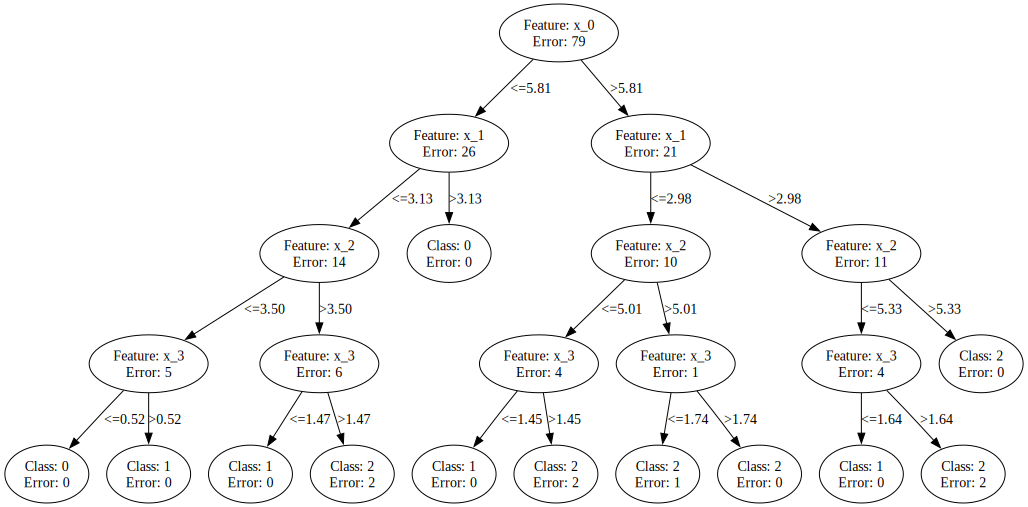

In [6]:
dt.show_tree()

In [7]:
dataset = {
    "Taste": [
        "Salty",
        "Spicy",
        "Spicy",
        "Spicy",
        "Spicy",
        "Sweet",
        "Salty",
        "Sweet",
        "Spicy",
        "Salty",
    ],
    "Temperature": [
        "Hot",
        "Hot",
        "Hot",
        "Cold",
        "Hot",
        "Cold",
        "Cold",
        "Hot",
        "Cold",
        "Hot",
    ],
    "Texture": [
        "Soft",
        "Soft",
        "Hard",
        "Hard",
        "Hard",
        "Soft",
        "Soft",
        "Soft",
        "Soft",
        "Hard",
    ],
    "Eat": ["No", "No", "Yes", "No", "Yes", "Yes", "No", "Yes", "Yes", "Yes"],
}
dataframe = pd.DataFrame(dataset, columns=["Taste", "Temperature", "Texture", "Eat"])

# Prepare features and target
feature_names = dataframe.columns[:-1].tolist()
x_train = dataframe[feature_names].to_numpy()
y_train = dataframe["Eat"].to_numpy()
classifier = DecisionTreeClassifier()
classifier.fit(x_train, y_train, features=feature_names, cat_features=feature_names)

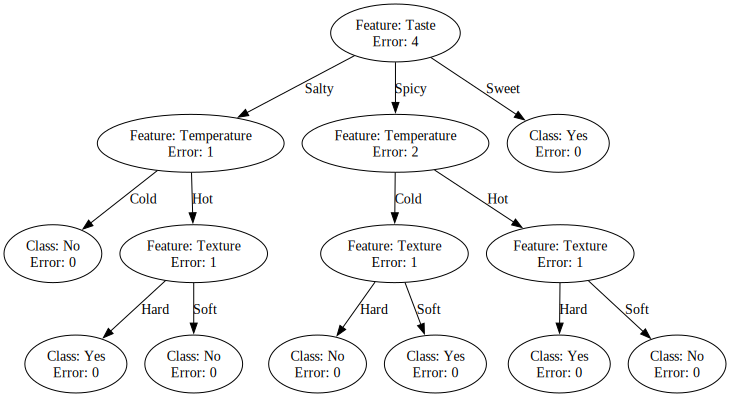

In [8]:
classifier.show_tree()

In [9]:
x_test = np.array([["Salty", "Hot", "Hard"]], dtype="object")
prediction = classifier.predict(x_test)
print(f"Prediction for the new data point(s): {prediction}")

Prediction for the new data point(s): ['Yes']


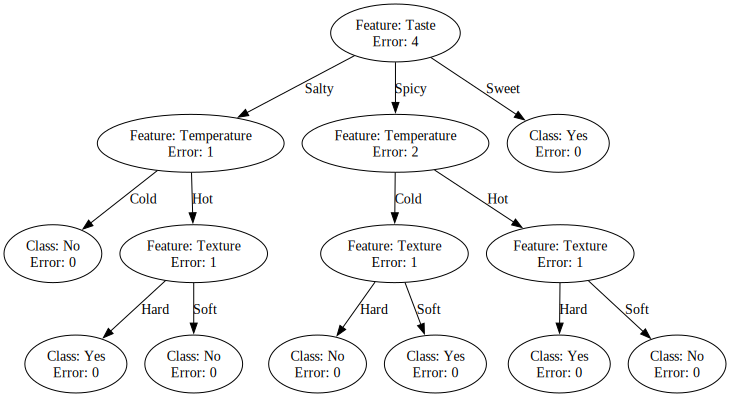

Prediction for the new data point(s): ['Yes']


In [10]:
# Prune the tree with alpha=0.1 (adjust alpha based on your needs)
alpha = 0.4
pruned_tree = classifier.get_pruned_tree(alpha=alpha)

# Visualize the pruned tree in Jupyter Notebook
pruned_tree.show_tree()

# Test prediction with the pruned tree
pruned_prediction = pruned_tree.predict(x_test)
print(f"Prediction for the new data point(s): {pruned_prediction}")